# Ad click prediction
Dataset link: https://www.kaggle.com/datasets/arashnic/ctr-in-advertisement/data?select=Ad_click_prediction_train+%281%29.csv

Given the data of ad clicks, I need to predict whether a user is going to click the ad or not.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier     
from sklearn.ensemble import RandomForestClassifier 
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV    

import pickle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mutual_info_score, f1_score
SEED = 42
np.random.seed(SEED)

In [2]:
df = pd.read_csv("Ad_click_prediction_train (1).csv")

## EDA

In [3]:
df.head()

,session_id,DateTime,user_id,product,campaign_id,webpage_id,product_category_1,product_category_2,user_group_id,gender,age_level,user_depth,city_development_index,var_1,is_click
0,140690,2017-07-02 00:00,858557,C,359520,13787,4,NaN,10.0,Female,4.0,3.0,3.0,0,0
1,333291,2017-07-02 00:00,243253,C,105960,11085,5,NaN,8.0,Female,2.0,2.0,NaN,0,0
2,129781,2017-07-02 00:00,243253,C,359520,13787,4,NaN,8.0,Female,2.0,2.0,NaN,0,0
3,464848,2017-07-02 00:00,1097446,I,359520,13787,3,NaN,3.0,Male,3.0,3.0,2.0,1,0
4,90569,2017-07-02 00:01,663656,C,405490,60305,3,NaN,2.0,Male,2.0,3.0,2.0,1,0


In [4]:
df.shape

(463291, 15)

In [5]:
df.columns = df.columns.str.lower()
df.columns

Index(['session_id', 'datetime', 'user_id', 'product', 'campaign_id',
       'webpage_id', 'product_category_1', 'product_category_2',
       'user_group_id', 'gender', 'age_level', 'user_depth',
       'city_development_index', 'var_1', 'is_click'],
      dtype='object')

In [6]:
df.describe().map(lambda x: '{:,.2f}'.format(x))

,session_id,user_id,campaign_id,webpage_id,product_category_1,product_category_2,user_group_id,age_level,user_depth,city_development_index,var_1,is_click
count,"463,291.00","463,291.00","463,291.00","463,291.00","463,291.00","97,437.00","445,048.00","445,048.00","445,048.00","338,162.00","463,291.00","463,291.00"
mean,"285,544.09","546,049.65","308,474.54","29,685.88",3.07,"162,753.35",3.48,2.78,2.88,2.56,0.42,0.07
std,"168,577.35","329,462.53","126,517.10","21,542.05",1.30,"78,743.74",2.41,1.07,0.40,0.92,0.49,0.25
min,2.00,4.00,"82,320.00","1,734.00",1.00,"18,595.00",0.00,0.00,1.00,1.00,0.00,0.00
25%,"137,856.50","257,855.00","118,601.00","13,787.00",2.00,"82,527.00",2.00,2.00,3.00,2.00,0.00,0.00
50%,"285,429.00","531,801.00","359,520.00","13,787.00",3.00,"146,115.00",3.00,3.00,3.00,2.00,0.00,0.00
75%,"435,535.50","827,849.00","405,490.00","53,587.00",4.00,"254,132.00",4.00,3.00,3.00,3.00,1.00,0.00
max,"595,812.00","1,141,729.00","414,149.00","60,305.00",5.00,"450,184.00",12.00,6.00,3.00,4.00,1.00,1.00


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 463291 entries, 0 to 463290
Data columns (total 15 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   session_id              463291 non-null  int64  
 1   datetime                463291 non-null  object 
 2   user_id                 463291 non-null  int64  
 3   product                 463291 non-null  object 
 4   campaign_id             463291 non-null  int64  
 5   webpage_id              463291 non-null  int64  
 6   product_category_1      463291 non-null  int64  
 7   product_category_2      97437 non-null   float64
 8   user_group_id           445048 non-null  float64
 9   gender                  445048 non-null  object 
 10  age_level               445048 non-null  float64
 11  user_depth              445048 non-null  float64
 12  city_development_index  338162 non-null  float64
 13  var_1                   463291 non-null  int64  
 14  is_click            

In [8]:
df["product"].value_counts()

product
C    163501
H    109574
I     63711
D     41064
B     22479
E     21452
A     15391
J      9698
G      9414
F      7007
Name: count, dtype: int64

In [9]:
df["gender"].value_counts()

gender
Male      393454
Female     51594
Name: count, dtype: int64

In [10]:
df["city_development_index"].value_counts()

city_development_index
2.0    147643
3.0     88709
4.0     67166
1.0     34644
Name: count, dtype: int64

In [11]:
df["var_1"].value_counts()

var_1
0    267704
1    195587
Name: count, dtype: int64

In [12]:
df["user_depth"].value_counts()

user_depth
3.0    402798
2.0     30389
1.0     11861
Name: count, dtype: int64

In [13]:
df["age_level"].value_counts()

age_level
3.0    160581
2.0    143501
4.0     63859
1.0     43367
5.0     30828
6.0      2759
0.0       153
Name: count, dtype: int64

In [14]:
df["webpage_id"].nunique()

9

In [15]:
df["campaign_id"].nunique()

10

In [16]:
df["user_id"].nunique()

150347

In [17]:
df["user_group_id"].value_counts()

user_group_id
3.0     140317
2.0     137278
4.0      50080
1.0      41946
5.0      21989
9.0      20264
10.0     13779
11.0      8839
8.0       6223
6.0       1724
7.0       1421
12.0      1035
0.0        153
Name: count, dtype: int64

In [18]:
df["product_category_1"].value_counts()

product_category_1
4    133290
3    113812
1     81141
2     69183
5     65865
Name: count, dtype: int64

In [19]:
df["product_category_2"].value_counts()

product_category_2
82527.0     35531
146115.0    25224
270915.0    19624
254132.0    12502
143597.0     2701
269093.0      858
32026.0       578
18595.0        76
408790.0       67
255689.0       62
419804.0       43
372532.0       41
66101.0        34
234846.0       25
235358.0       19
450184.0       14
408831.0       12
327439.0        8
300711.0        4
447834.0        3
99226.0         2
168114.0        2
381435.0        1
301147.0        1
419304.0        1
181650.0        1
270147.0        1
202351.0        1
247789.0        1
Name: count, dtype: int64

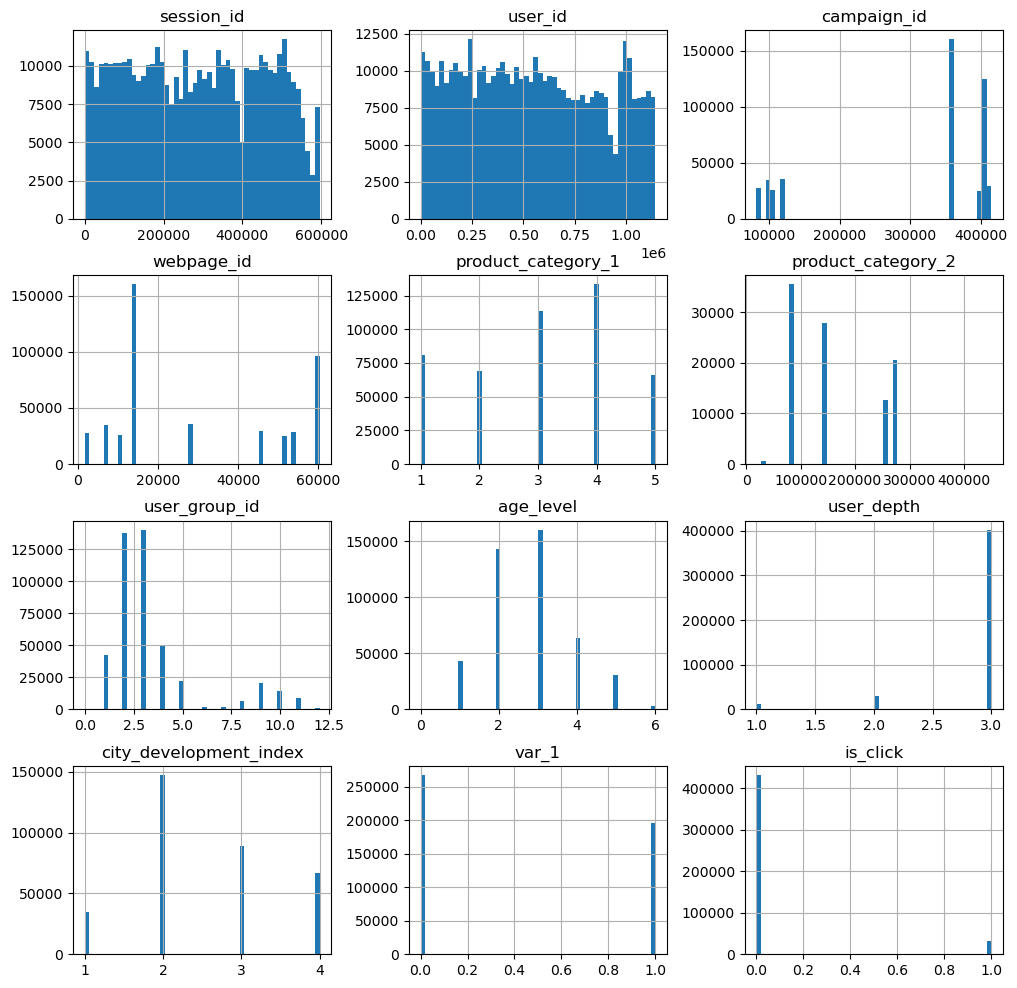

In [20]:
df.hist(bins=50, figsize=(12, 12))
plt.show()

<Axes: xlabel='datetime'>

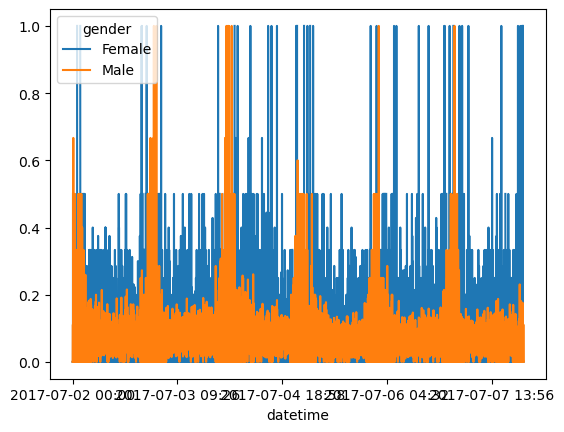

In [21]:
df.groupby(['datetime', 'gender'])['is_click'].mean().unstack().plot()

In [22]:
df["datetime"] = pd.to_datetime(df["datetime"])

In [23]:
df["is_click"].value_counts()

is_click
0    431960
1     31331
Name: count, dtype: int64

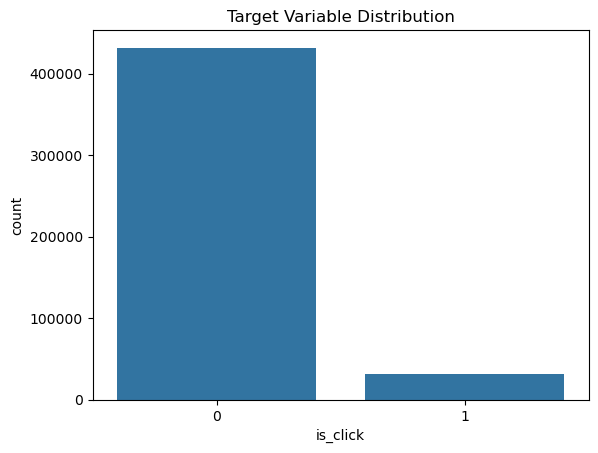

Class Proportions:
is_click
0    93.237296
1     6.762704
Name: proportion, dtype: float64


In [24]:
# Distribution of target variable
sns.countplot(x=df.is_click, data=df.iloc[:, :-1])
plt.title("Target Variable Distribution")
plt.show()

print("Class Proportions:")
print(df["is_click"].value_counts(normalize=True) * 100)

### Handle missing values

In [23]:
df.isnull().sum()

session_id                     0
datetime                       0
user_id                        0
product                        0
campaign_id                    0
webpage_id                     0
product_category_1             0
product_category_2        365854
user_group_id              18243
gender                     18243
age_level                  18243
user_depth                 18243
city_development_index    125129
var_1                          0
is_click                       0
dtype: int64

In [24]:
df.drop(columns=["product_category_2"], inplace=True)

# Drop rows with missing values in the specified columns
columns_to_check = ['user_group_id', 'gender', 'age_level', 'user_depth']
df = df.dropna(subset=columns_to_check)

In [25]:
null_indices = df[df['city_development_index'].isnull()].index

# Generate random values (1, 2, 3, 4) with equal probabilities
random_values = np.random.choice([1, 2, 3, 4], size=len(null_indices), replace=True)

# Assign random values to the null indices
df.loc[null_indices, 'city_development_index'] = random_values

In [26]:
df.isnull().sum()

session_id                0
datetime                  0
user_id                   0
product                   0
campaign_id               0
webpage_id                0
product_category_1        0
user_group_id             0
gender                    0
age_level                 0
user_depth                0
city_development_index    0
var_1                     0
is_click                  0
dtype: int64

### Feature importance

In [27]:
def mutual_info_ctr_score(series):
    return mutual_info_score(series, df.is_click)

In [28]:
mi = df.iloc[:, :-1].apply(mutual_info_ctr_score)
mi.sort_values(ascending=False)

session_id                0.247220
user_id                   0.126145
datetime                  0.010739
campaign_id               0.001758
webpage_id                0.001619
product_category_1        0.000774
product                   0.000356
user_group_id             0.000234
age_level                 0.000221
var_1                     0.000071
city_development_index    0.000030
gender                    0.000010
user_depth                0.000006
dtype: float64

## Create a train/test split

In [29]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=SEED, shuffle=True)

In [30]:
len(df_train), len(df_test)

(356038, 89010)

In [31]:
y_train = df_train.is_click.values
y_test = df_test.is_click.values

del df_train["is_click"]
del df_test["is_click"]

### Prepare data

In [32]:
df_train['hour'] = df_train['datetime'].dt.hour
df_train.drop(columns=["datetime"], inplace=True)

In [33]:
dv = DictVectorizer(sparse=False)

In [34]:
train_dicts = df_train.to_dict(orient="records")
X_train = dv.fit_transform(train_dicts)

In [35]:
dv.get_feature_names_out()

array(['age_level', 'campaign_id', 'city_development_index',
       'gender=Female', 'gender=Male', 'hour', 'product=A', 'product=B',
       'product=C', 'product=D', 'product=E', 'product=F', 'product=G',
       'product=H', 'product=I', 'product=J', 'product_category_1',
       'session_id', 'user_depth', 'user_group_id', 'user_id', 'var_1',
       'webpage_id'], dtype=object)

In [36]:
X_train[:5]

array([[1.00000e+00, 3.59520e+05, 2.00000e+00, 0.00000e+00, 1.00000e+00,
        9.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 4.00000e+00, 1.26751e+05, 3.00000e+00, 1.00000e+00,
        6.63653e+05, 0.00000e+00, 1.37870e+04],
       [2.00000e+00, 1.18601e+05, 2.00000e+00, 0.00000e+00, 1.00000e+00,
        1.40000e+01, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00,
        0.00000e+00, 5.00000e+00, 5.66052e+05, 3.00000e+00, 2.00000e+00,
        5.34364e+05, 0.00000e+00, 2.85290e+04],
       [3.00000e+00, 4.14149e+05, 3.00000e+00, 0.00000e+00, 1.00000e+00,
        1.10000e+01, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 5.00000e+00, 1.66348e+05, 3.00000e+00, 3.00000e+00,
        3.24020e+04, 1.00000

In [37]:
std_scaler = StandardScaler()

In [38]:
X_train = std_scaler.fit_transform(X_train)

### Training

In [39]:
classifiers = {
    'lr':LogisticRegression(random_state=SEED),
    'sgd':SGDClassifier(random_state=SEED),
    'dt':DecisionTreeClassifier(random_state=SEED),             
    'rf':RandomForestClassifier(random_state=SEED),            
    'xgb':XGBClassifier(random_state=SEED)                      
}

In [40]:
results = {}
for clf in classifiers:
    model = classifiers[clf]
    score = cross_val_score(model, X_train, y_train, cv=5, scoring = 'f1').mean()
    results[clf] = round(score, 2)

In [46]:
results

{'lr': 0.0, 'sgd': 0.0, 'dt': 0.08, 'rf': 0.01, 'xgb': 0.0}

### Fine tune

In [47]:
negative_class = len(y_train[y_train == 0])
positive_class = len(y_train[y_train == 1])
scale_pos_weight = negative_class / positive_class

# Initialize Decision Tree Classifier
dt = DecisionTreeClassifier(random_state=SEED, class_weight={0: 1, 1: scale_pos_weight})

# Define the parameter grid
param_grid = {
    'max_depth': [3, 5, 7, 10],            # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],      # Minimum number of samples required to split
    'min_samples_leaf': [1, 5, 10]       # Minimum number of samples required in a leaf node
    
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    scoring='f1',     # Optimize for F1 score
    cv=5,             # 5-fold cross-validation
    verbose=1         # Display progress
)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best F1 Score:", grid_search.best_score_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Parameters: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best F1 Score: 0.14941897727215223


In [48]:
max_depth = grid_search.best_params_["max_depth"]
min_samples_split = grid_search.best_params_["min_samples_split"]
min_samples_leaf = grid_search.best_params_["min_samples_leaf"]

### using the model

In [49]:
df_test['hour'] = df_test['datetime'].dt.hour
df_test.drop(columns=["datetime"], inplace=True)

test_dicts = df_test.to_dict(orient="records")
X_test = dv.transform(test_dicts)

X_test = std_scaler.transform(X_test)

In [50]:
dt = DecisionTreeClassifier(max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, random_state=SEED, class_weight={0: 1, 1: scale_pos_weight})
dt.fit(X_train, y_train)

y_pred = dt.predict(X_test)
print("Test F1 Score:", f1_score(y_test, y_pred))

Test F1 Score: 0.15001491201908737


In [56]:
output_file = "model.bin"
with open(output_file, 'wb') as f_out:
    pickle.dump((dv, std_scaler, dt), f_out)